# RNN 기반 텍스트 분류 

In [1]:
#-*- coding: utf-8 -*-
import re
import konlpy
import numpy as np
from glob import glob 
import os.path as path
from scipy.sparse import csr_matrix
from tensorflow.contrib import learn

seed = 1234

In [2]:
import data_helpers
emo_class = "happiness,sadness,contempt,awo".split(',')
# emo_class = "anger,happiness".split(',')
morph = True

x_text, x_orig, y = data_helpers.load_data_and_labels2(emo_class=emo_class, _morph=morph)
vocab_processor, x_train, y_train, x_dev, y_dev, x_train_text, x_dev_text, x_train_text_orig, x_dev_text_orig = data_helpers.make_voca_and_train_dev(x_text,x_orig, y)

# of happiness : 1306
# of sadness : 1876
# of contempt : 5878
# of awo : 1923
x_text 10983
y 10983
Vocabulary Size: 9780
Train/Dev split: 9336/1647


In [3]:
max_document_length = max([len(x.split(" ")) for x in x_text])

In [7]:
import tensorflow as tf


acs = []
with tf.Session() as sess:
    X = tf.placeholder(dtype=tf.float32, shape=[None, max_document_length])
    Y = tf.placeholder(dtype=tf.float32, shape=[None, len(emo_class)])
    
    # layer 1
    W1 = tf.Variable(tf.random_uniform([max_document_length, 100]))
    b1 = tf.Variable(tf.random_uniform([100]))
    r1 = tf.nn.relu(tf.matmul(X, W1) + b1)
    
    keep_prob = tf.placeholder("float")
    r1_drop = tf.nn.dropout(r1, keep_prob)
    
    # layer 2
    W2 = tf.Variable(tf.random_uniform([100, 50]))
    b2 = tf.Variable(tf.random_uniform([50]))
    r2 = tf.nn.relu(tf.matmul(r1_drop, W2) + b2)
    
    r2_drop = tf.nn.dropout(r2, keep_prob)

    # layer 3
    W3 = tf.Variable(tf.random_uniform([50, len(emo_class)]))
    b3 = tf.Variable(tf.random_uniform([len(emo_class)]))
    r3 = tf.nn.relu(tf.matmul(r2_drop, W3) + b3)
    
    # r3 이용해서 softmax한 결과를 저장하는 노드생성
    predict=tf.nn.softmax(tf.matmul(r2_drop, W3) + b3)
    
    # predict ~~
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=r3, labels=Y))
#     cross_entropy = tf.reduce_mean(-tf.reduce_sum(Y * tf.log(r2), reduction_indices=[1]))

    learning_rate = 0.01
    
    #train
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)
    
    #test
    correct_prediction = tf.equal(tf.argmax(Y, 1), tf.argmax(r3, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    sess.run(tf.global_variables_initializer())
    
    for epoch in range(300):
        # train
        sess.run(optimizer, feed_dict={X:x_train, Y:y_train, keep_prob:0.5})
        if not epoch % 30:
            acc = sess.run(accuracy, feed_dict={X:x_dev, Y:y_dev, keep_prob:1.0})
            print('epoch : %10d, accuracy : %.5f' % (epoch, acc))
            acs.append((epoch, acc))
    # data 입력
    # data clean_str->vocab transform)
    string_text = input()
 
    x_test = data_helpers.clean_str(string_text, True)

    x = np.array(list(vocab_processor.transform([x_test])))
    
    result = sess.run(predict, feed_dict={X:x, keep_prob:1.0})
    print('%d' % (np.argmax(result,1)))

epoch :          0, accuracy : 0.53977
epoch :         30, accuracy : 0.53977
epoch :         60, accuracy : 0.17304
epoch :         90, accuracy : 0.53977
epoch :        120, accuracy : 0.17122
epoch :        150, accuracy : 0.17304
epoch :        180, accuracy : 0.52702
epoch :        210, accuracy : 0.19854
epoch :        240, accuracy : 0.53977
epoch :        270, accuracy : 0.54038
어우 씨 재수없어
2


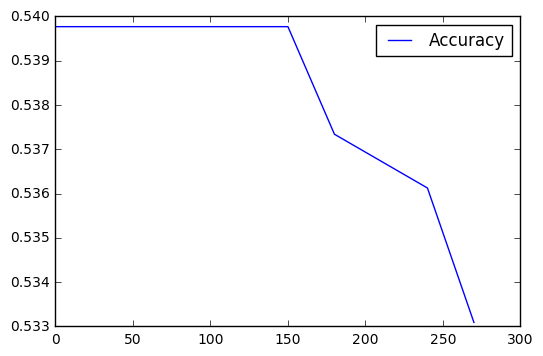

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
acs = np.array(acs)
plt.plot(acs[:, 0], acs[:, 1], label='Accuracy')
plt.legend()
plt.show()